#  DenseNet121 ile Transfer Learning

Ödev kapsamında bir göz hastalığı sınıflandırma problemi için DenseNet121 modelini kullandım. Modeli sıfırdan eğitmek yerine, ImageNet veri kümesinde önceden eğitilmiş ağırlıkları kullanarak fine-tuning yöntemi uyguladım.Overfitting'i önlemek ve eğitim süresini azaltmak amacıyla Early Stopping kullandım.Eğitim sırasında validation loss 5 epoch boyunca iyileşmezse duracak.Orijinal veriler ile işlenmiş veriler üzerinde modeli uyguladıktan sonra model performans karşılaştırması kapsamında grafik oluşturdum.

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.2599 - loss: 1.9038 - val_accuracy: 0.2950 - val_loss: 1.6224
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.3440 - loss: 1.5348 - val_accuracy: 0.3200 - val_loss: 1.7202
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4081 - loss: 1.4162 - val_accuracy: 0.3300 - val_loss: 1.5425
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4513 - loss: 1.3301 - val_accuracy: 0.2850 - val_loss: 1.5776
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4423 - loss: 1.2718 - val_accuracy: 0.3150 - val_loss: 1.5176
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4730 - loss: 1.2308 - val_accuracy: 0.3350 - val_loss: 1.5124
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5044 - loss: 1.2079 - val_accuracy: 0.3050 - val_loss: 1.5272
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5532 - loss: 1.1396 - val_accuracy: 0.3300 - val_loss

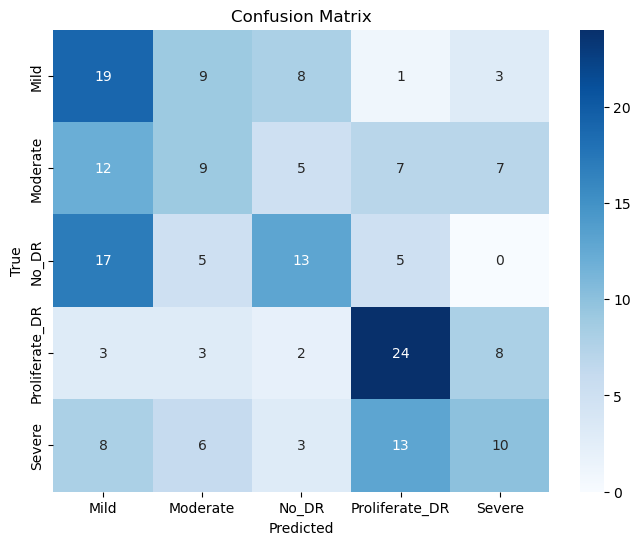

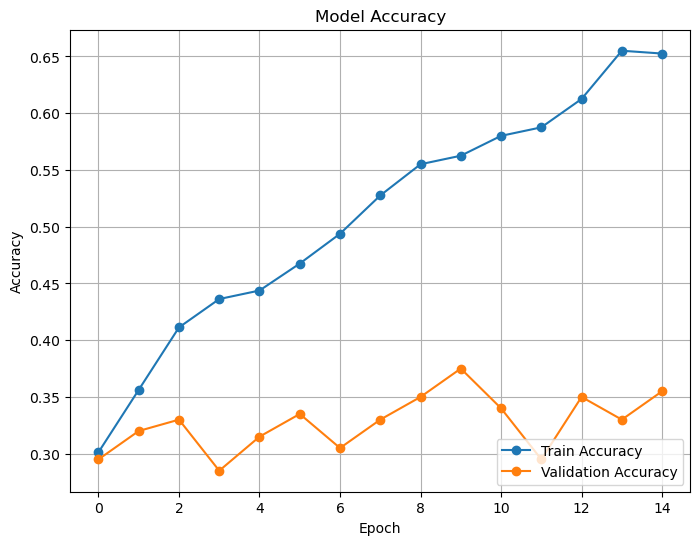

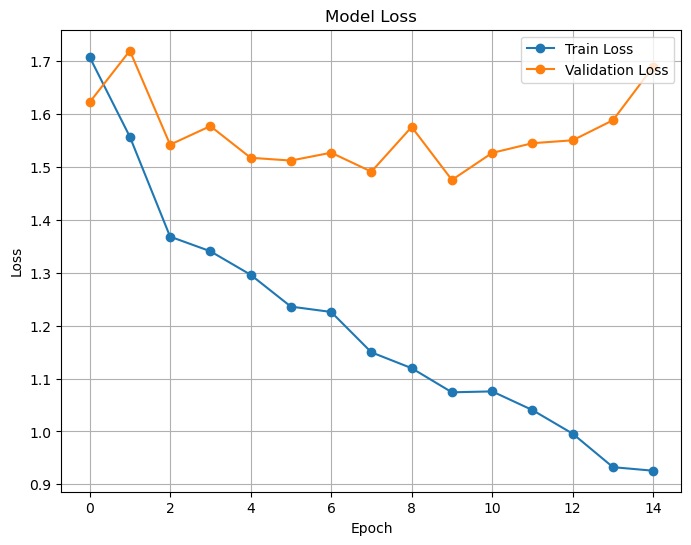

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.Dataset Yükleme
data_dir = r'C:/Users/USER/Desktop/colored_dataset'  

img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

# 2. Model Oluşturma (DenseNet121)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # İlk başta pretrained ağı donduruyoruz

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 4. Model Eğitimi
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# 5. Model Değerlendirme

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Eğitim ve doğrulama accuracy çizimi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Eğitim ve doğrulama loss çizimi
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Epoch 1/50


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2508 - loss: 1.6099 - val_accuracy: 0.2300 - val_loss: 1.6180
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4290 - loss: 1.3903 - val_accuracy: 0.2500 - val_loss: 1.5893
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3959 - loss: 1.3839 - val_accuracy: 0.2450 - val_loss: 1.5367
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4761 - loss: 1.2897 - val_accuracy: 0.3050 - val_loss: 1.5148
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5333 - loss: 1.2547 - val_accuracy: 0.3100 - val_loss: 1.5007
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5352 - loss: 1.1979 - val_accuracy: 0.3000 - val_loss: 1.5176
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5202 - loss: 1.1758 - val_accuracy: 0.3200 - val_loss: 1.5122
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5283 - loss: 1.1713 - val_accuracy: 0.3550 - val_loss: 1.4656
Epo

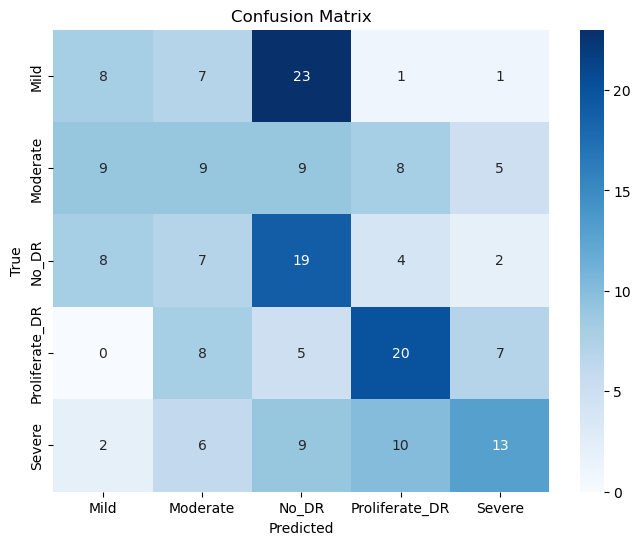

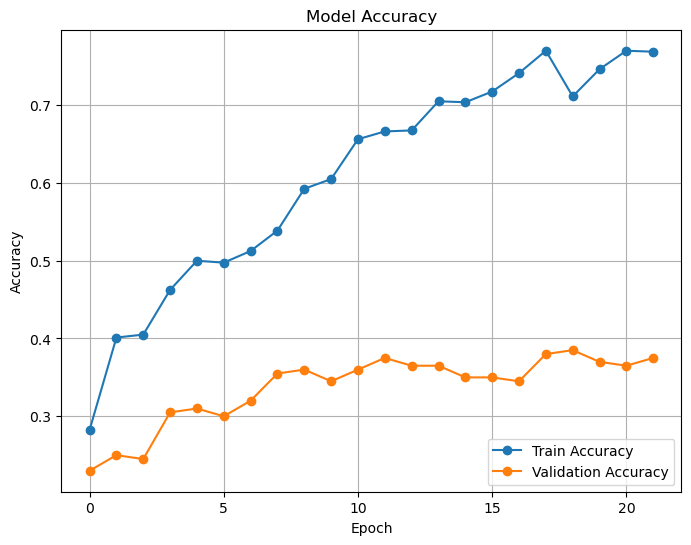

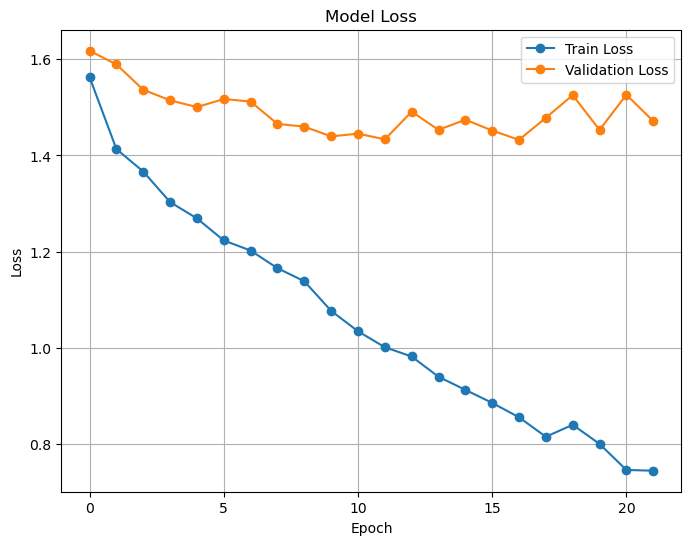

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataset Yükleme
data_dir = r'C:/Users/USER/Desktop/processed_dataset'  

img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

# 2. Model Oluşturma (DenseNet121)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Fine-tuning için son 4 katmanı serbest bırakıyoruz
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Sonra modelin yeni katmanlarını ekliyoruz
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)  # İhtiyaca göre katman ekleyebilirsiniz
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Modeli Derleyin
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# 4. EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 5. Model Eğitimi
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# 6. Model Değerlendirme

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Eğitim ve doğrulama accuracy çizimi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Eğitim ve doğrulama loss çizimi
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### Model Performans Karşılaştırması

          Ölçüt  Model 1 (%)  Model 2 (%)
0      Accuracy         38.0         34.0
1     Precision         37.0         35.0
2        Recall         38.0         34.0
3      F1-Score         37.0         34.0
4   Specificity         86.6         83.6


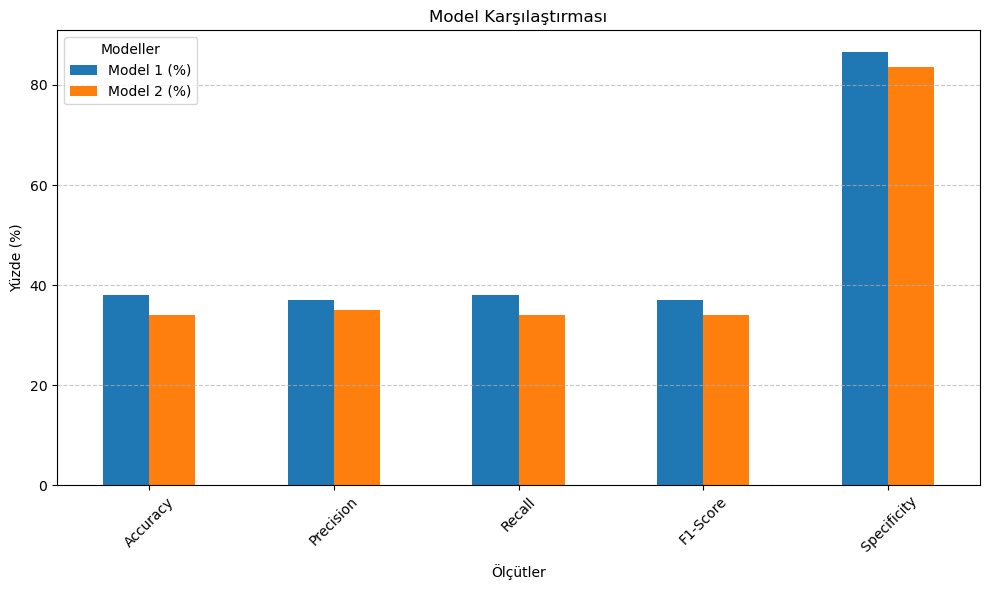

In [11]:
import pandas as pd

# Verileri sözlük yapısında oluşturuyoruz
data = {
    "Ölçüt": ["Accuracy", "Precision", "Recall", "F1-Score", " Specificity"],
    "Model 1 (%)": [38, 37, 38, 37, 86.6],
    "Model 2 (%)": [34, 35, 34, 34, 83.6]
}

# DataFrame oluştur
df = pd.DataFrame(data)

# Tabloyu yazdır
print(df)

# (Opsiyonel) Eğer tabloyu görsel olarak da göstermek istersen:
try:
    import matplotlib.pyplot as plt

    df_plot = df.set_index("Ölçüt")
    df_plot.plot(kind="bar", figsize=(10,6))
    plt.title("Model Karşılaştırması")
    plt.ylabel("Yüzde (%)")
    plt.xlabel("Ölçütler")
    plt.legend(title="Modeller")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib yüklü değil, sadece tablo yazdırıldı.")
